# Домашнее задание №2, часть 2 #
### Елизавета Клыкова, БКЛ181 ###
В первую очередь включим проверку на PEP-8, затем импортируем все модули, которые понадобятся для работы программы.

In [1]:
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
# ! pip install wordcloud
import collections
import json
import re
import nltk
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud
from nltk import *
from nltk.collocations import *
from nltk.corpus import stopwords
from operator import itemgetter
import matplotlib.pyplot as plt
%matplotlib inline
# nltk.download("stopwords")

## Пункт 1 (DataFrame) ##
Переведем выполненную в первой части домашнего задания морфологическую разметку в датафрейм. Я буду использовать разметку Pymorphy.

Для начала откроем файл "pymorphy.json" и достанем хранящуюся в нем разметку в формате json с помощью json.load. (Файл должен быть расположен в одной директории с данной программой).

**Примечание.** Поскольку файл очень большой и не заливается на Github, то вот ссылка на него на Google-диске: https://drive.google.com/open?id=1c8jarCOhwWdpEGBgfsco027CS0RDRXdP.

In [3]:
with open("pymorphy.json", encoding="utf-8") as f:
    pymorphy_json = json.load(f)

У многих словоформ в файле хранится несколько вариантов разметки; для датафейма возьмем только первый, наиболее вероятный разбор каждого слова. Создадим пустой список lexemes и по очереди добавим в него словари с разбором словоформ. При этом будем проверять, что данная словоформа не является знаком препинания, и удалим поля "full_tags", чтобы не захламлять будущую таблицу.

Каждый словарь будет иметь следующую структуру:

{"wordform": "словоформа", "normal_form": "начальная форма", "POS": "часть речи", "animacy": "одушевленность", ..., "voice": "залог"}

In [4]:
lexemes = []
for token in pymorphy_json:
    word = {}
    wordform = list(token.keys())[0]
    word["wordform"] = wordform
    word["normal_form"] = token[wordform]["option_1"]["normal_form"]
    word.update(token[wordform]["option_1"]["tags"])
    if word["POS"] != "PNCT":
        del word["full_tags"]
        lexemes.append(word)

По полученному списку разборов создадим датафрейм:

In [5]:
pymorphy_df = pd.DataFrame(lexemes)
pymorphy_df

,wordform,normal_form,POS,animacy,aspect,case,gender,involvement,mood,number,person,tense,transitivity,voice
0,мы,мы,NPRO,None,None,nomn,None,None,None,plur,1per,None,None,None
1,евгений,евгений,NOUN,anim,None,nomn,masc,None,None,sing,None,None,None,None
2,иванович,иван,NOUN,anim,None,nomn,masc,None,None,sing,None,None,None,None
3,замятин,замятин,NOUN,anim,None,nomn,masc,None,None,sing,None,None,None,None
4,мы,мы,NPRO,None,None,nomn,None,None,None,plur,1per,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45090,в,в,PREP,None,None,None,None,None,None,None,None,None,None,None
45091,iii,iii,None,None,None,None,None,None,None,None,None,None,None,None
45092,веке,век,NOUN,inan,None,loct,masc,None,None,sing,None,None,None,None
45093,после,после,PREP,None,None,None,None,None,None,None,None,None,None,None


Теперь сохраним полученную таблицу в файл "dataframe.csv".

In [6]:
pymorphy_df.to_csv("dataframe.csv", sep="\t", encoding="utf-8", index=False)

## Пункт 2 (графики) ##
Все эти графики были на семинаре в том или ином виде, я внесла некоторые незначительные изменения.
### Графики 1a и 1b ###
Построим две столбчатые диаграммы, отражающие количество употреблений наиболее частотных глаголов и наречий. Для начала немного модифицируем алгоритм получения данных, использованный в 1-ой части д/з 2. Объявим функцию, составляющую два списка: список 20 наиболее частотных лексем и список с количествами их употреблений.

In [7]:
def common_POS(POS):
    all_lex = [lex["normal_form"] for lex in lexemes if lex["POS"] == POS]
    Lcounter = collections.Counter(all_lex)
    common_lex = []
    lex_amount = []
    for i, lex in enumerate(sorted(Lcounter, key=Lcounter.get, reverse=True)):
        if i < 20:
            common_lex.append(lex)
            lex_amount.append(Lcounter[lex])
    return common_lex, lex_amount

In [8]:
common_verbs, verbs_amount = common_POS("VERB")
common_adverbs, adverbs_amount = common_POS("ADVB")

Теперь построим два графика (один для глаголов, второй для наречий) по образцу тех, что были в конспекте семинара для распределения ругательств по дням недели.

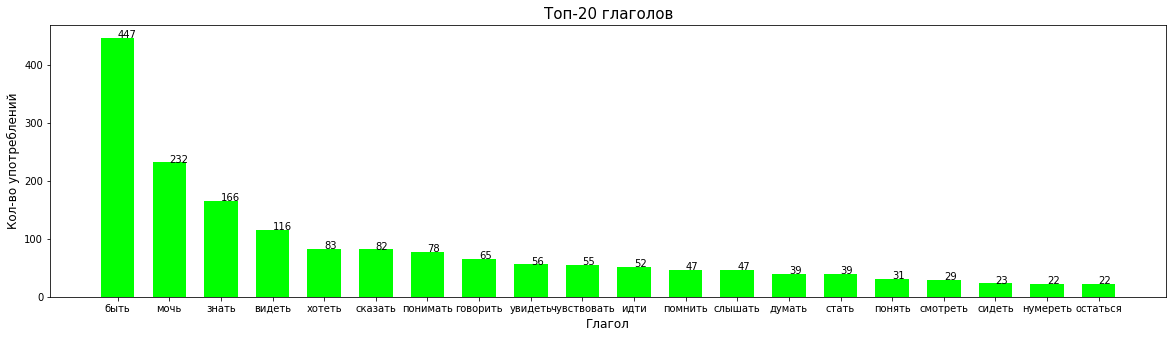

In [9]:
plt.figure(figsize=(20, 5))
plt.bar(common_verbs, verbs_amount, width=0.65, color="lime")
plt.xticks(ticks=common_verbs, labels=common_verbs)
plt.title("Топ-20 глаголов", fontsize=15)
plt.ylabel("Кол-во употреблений", fontsize=12)
plt.xlabel("Глагол", fontsize=12)

for verb, count in zip(common_verbs, verbs_amount):
    plt.text(verb, count, count)

plt.show()

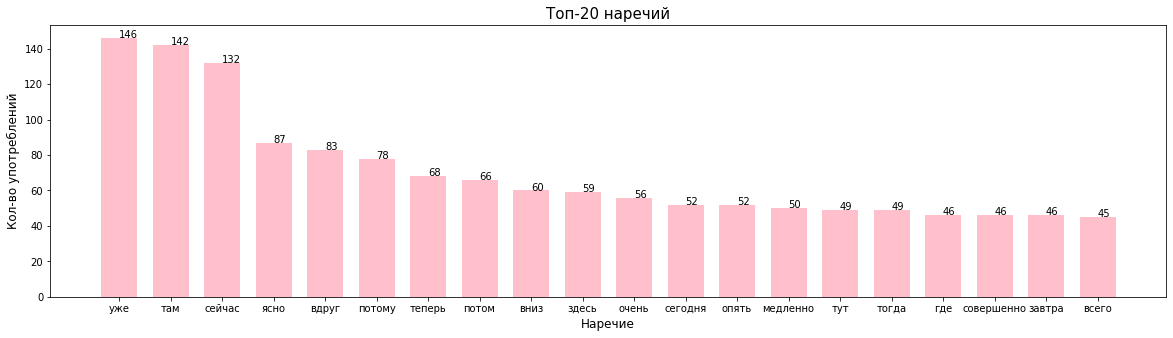

In [10]:
plt.figure(figsize=(20, 5))
plt.bar(common_adverbs, adverbs_amount, width=0.7, color="pink")
plt.xticks(ticks=common_adverbs, labels=common_adverbs)
plt.title("Топ-20 наречий", fontsize=15)
plt.ylabel("Кол-во употреблений", fontsize=12)
plt.xlabel("Наречие", fontsize=12)

for adverb, count in zip(common_adverbs, adverbs_amount):
    plt.text(adverb, count, count)

plt.show()

### График 2 ###
Построим график, отражающий употребление различных родов (по образцу семинара).

Text(0, 0.5, 'number of entries')

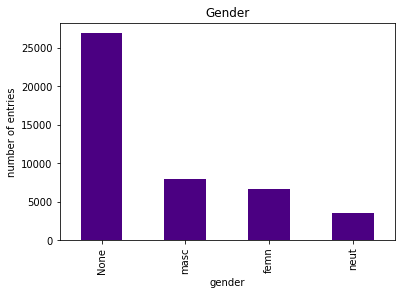

In [11]:
pymorphy_df["gender"].value_counts().plot.bar(color="indigo")
plt.title("Gender")
plt.xlabel("gender")
plt.ylabel("number of entries")

### График 3 ###
Построим круговую диаграмму, отражающую доли **существительных** различного рода. Сначала отберем все значения поля "gender" у существительных в список genders, затем создадим частотный словарь по этому списку и на основании словаря создадим диаграмму.

**Примечание.** Ниже есть более удобный способ сделать то же самое на основе датафрейма (по образцу семинара).

Text(0.5, 1.0, 'Noun genders')

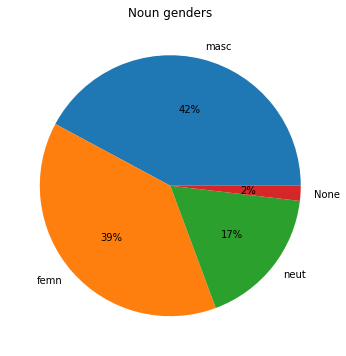

In [12]:
genders = []
for lexeme in lexemes:
    if lexeme["POS"] == "NOUN":
        gender = lexeme["gender"]
        genders.append(gender)
Gcount = collections.Counter(genders)
plt.figure(figsize=(6, 6))
plt.pie(list(Gcount.values()), labels=list(Gcount.keys()), autopct="%.0f%%")
plt.title("Noun genders")

Text(0.5, 1.0, 'Noun genders')

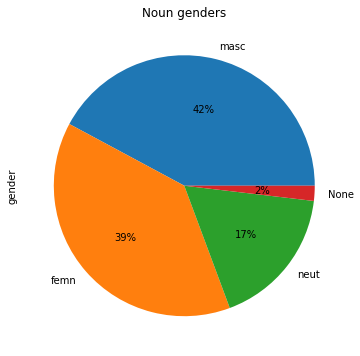

In [13]:
plt.figure(figsize=(6, 6))
pymorphy_df[pymorphy_df["POS"] == "NOUN"][
    "gender"].value_counts().plot(kind="pie", autopct="%.0f%%")
plt.title("Noun genders")

### График 4 ###
Построим столбчатую диаграмму с группировкой, отражающую количество слов разных родов по разным частям речи (по образцу семинара).

Text(0, 0.5, 'number of entries')

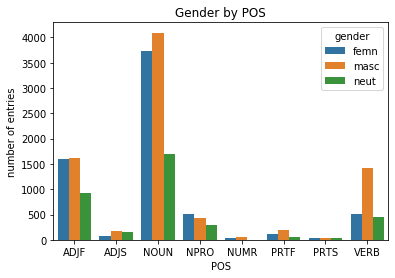

In [14]:
pydf = pymorphy_df[(pymorphy_df["gender"] != "None")][
    ["POS", "gender", "number"]
].groupby(["POS", "gender"], as_index=False).count()

pydf.columns = ["POS", "gender", "total"]
sns.barplot(x="POS", y="total", hue="gender", data=pydf)
plt.title("Gender by POS")
plt.xlabel("POS")
plt.ylabel("number of entries")

## Пункт 3 (визуализации) ##
**Примечание.** Я сделала больше двух, потому что так и не смогла понять, достаточно ли они все отличаются от того, что было на семинаре.
### Визуализация №1 ###
Построим горизонтальную столбчатую диаграмму, отражающую среднюю длину слов разных частей речи. Здесь хорошо использовать такой тип графика, т.к. нам нужно посмотреть, как соотносятся значения у разных категорий. Нельзя использовать, например, круговую диаграмму, т.к. интересующие нас значения - не доли внутри целого.

Сначала добавим в датафрейм столбец "length", содержащий длину лексемы. Затем посчитаем среднее значение внутри каждой части речи (кроме PNCT и None) и округлим его до двух знаков после запятой. Получится такая таблица:

In [15]:
pymorphy_df["length"] = pymorphy_df["normal_form"].apply(len)
pymorphy_df[(pymorphy_df["POS"] != "PNCT") & (pymorphy_df["POS"] != "None")
            ].groupby("POS").mean().round(decimals=2)

,length
POS,
ADJF,6.85
ADJS,8.01
ADVB,5.95
COMP,7.46
CONJ,2.57
GRND,8.70
INFN,7.09
INTJ,3.50
NOUN,5.78


Наконец, построим диаграмму по полученным данным, отсортировав значения средней длины в порядке убывания.

Text(0, 0.5, 'POS')

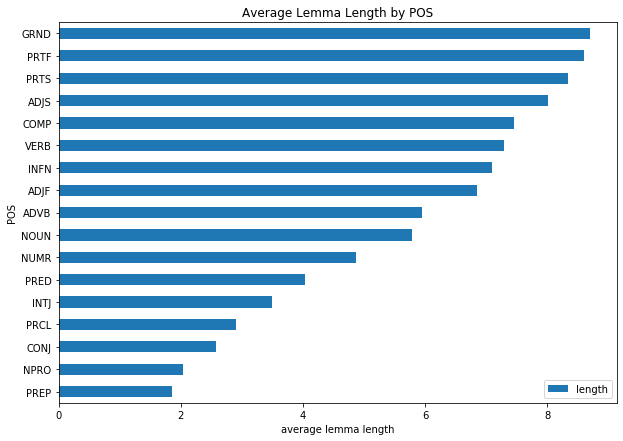

In [16]:
pymorphy_df[(pymorphy_df["POS"] != "PNCT") & (pymorphy_df["POS"] != "None")
            ].groupby("POS").mean().round(2).sort_values(
    "length").plot(kind="barh", figsize=(10, 7))
plt.title("Average Lemma Length by POS")
plt.xlabel("average lemma length")
plt.ylabel("POS")

### Визуализация №2 ###
Следующая визуализация - это stacked bar plot, отражающий взаимосвязь части речи и лица (т.е. число употреблений глаголов настоящего/будущего времени и личных местоимений разного лица). Здесь интересно использовать именно такой график, чтобы иметь возможность сравнить, какую долю занимает каждое лицо от всех употреблений данной части речи.

Text(0, 0.5, 'Person')

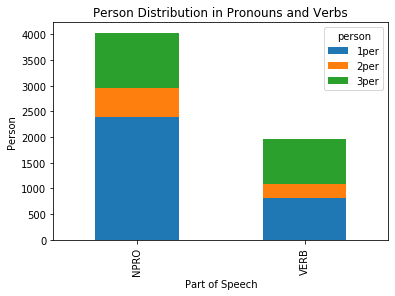

In [17]:
pymorphy_df[(pymorphy_df["person"] != "None") & (pymorphy_df["POS"] != "None")
            ].groupby(["POS", "person"])["POS"].count().unstack(
    "person").plot(kind='bar', stacked=True)
plt.title("Person Distribution in Pronouns and Verbs")
plt.xlabel("Part of Speech")
plt.ylabel("Person")

Можно заметить, что при схожести ситуаций некоторые различия все же есть: если у глаголов число употреблений в 1-м и 3-м лицах примерно равное, то в случае с личными местоимениями наблюдается перевес в пользу местоимений 1-го лица. Это легко объясняется тем, что повествование в романе "Мы" ведется от первого лица. Понятно и сравнительно небольшое число употреблений 2-го лица: оно используется в основном в прямой речи, которой в данном произведении не так уж много.

### Визуализация №3 ###
Построим гистограмму, отражающую количество слов в предложениях текста. В данном случае нужно использовать именно такой тип графика, т.к. нас интересует только одна переменная (кол-во слов в предложении) и мы хотим узнать, сколько всего предложений разной длины у нас имеется.
Первый шаг - считать исходный текст из файла "hw2_txt.txt" (файл и программа должны лежать в одной директории!) и разделить его на предложения по знакам .!?… . Далее каждое предложение разделить на слова, удаляя пустые элементы и знаки препинания, которые посчитались как отдельные слова (- и –).

In [18]:
with open("hw2_txt.txt", encoding="utf-8") as t:
    sentences = [s for s in re.split(r"[.!?…]", t.read()) if s != ""]
    split_sent = [re.split(r"[\s]+", s) for s in sentences]
    clean = []
    for sent in split_sent:
        clean_s = [s for s in sent if s != "–" and s != "-" and s != ""]
        if clean_s != []:
            clean.append(clean_s)

Теперь создадим список из длин всех предложений. Заодно посчитаем среднее количество слов в предложении данного текста (в среднем длина предложения в русском языке, кажется, 10.38 слова):

In [19]:
sen_length = [len(s) for s in clean]
average_len = sum(sen_length) / len(sen_length)
print("Средняя длина предложения (в словах):", round(average_len, 2))

Средняя длина предложения (в словах): 10.59


Text(0.5, 0, 'Sentence length')

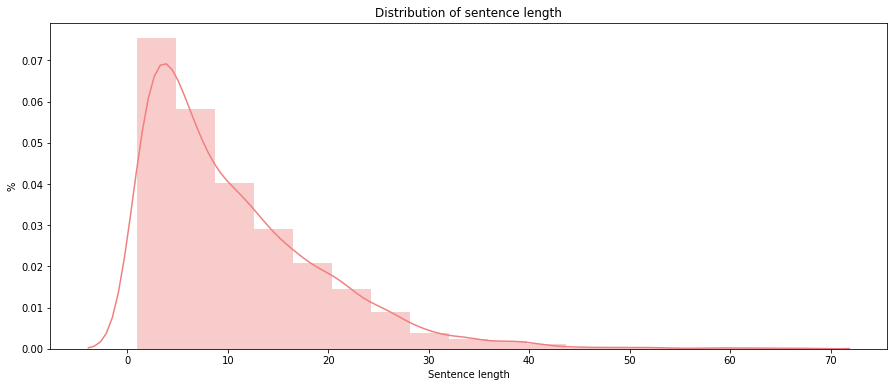

In [20]:
plt.figure(figsize=(15, 6))
sns.distplot(sen_length, bins=17, color="lightcoral")
plt.title("Distribution of sentence length")
plt.ylabel('%')
plt.xlabel("Sentence length")

### Визуализация №4 ###
Последняя визуализация - wordcloud для биграмм. На мой взгляд, биграммы более наглядно отражают содержание текста, чем одиночные слова, поэтому я составляю визуализацию именно для них.

Мне показалось более интересным использовать биграммы словоформ, а не лексем, поэтому первым шагом создаем список словоформ текста, очищаем его от стоп-слов и проверяем, что в список не попали пустые элементы:

In [21]:
stops = set(stopwords.words('russian') + ["весь", "все", "вся", "всё", "это"])

w_list = [lexeme["wordform"] for lexeme in lexemes]
nostops_w = [word for word in w_list if word not in stops]
clean_w = [word for word in nostops_w if len(word) != 0]

Создадим список биграмм и их частотностей:

In [22]:
finder = BigramCollocationFinder.from_words(clean_w)
bigram_measures = BigramAssocMeasures()
scored = finder.score_ngrams(bigram_measures.raw_freq)
scoredList = sorted(scored, key=itemgetter(1), reverse=True)

Соединим слова в биграммах с помощью "_", чтобы при визуализации словосочетания не разрывались другими, и построим wordcloud:

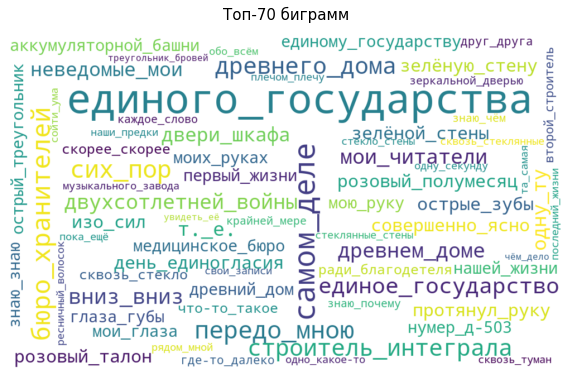

In [23]:
word_dict = {}
for i in range(len(scoredList)):
    word_dict["_".join(scoredList[i][0])] = scoredList[i][1]

wordCloud = WordCloud(background_color="white",
                      height=600, width=1000, max_words=70)
wordCloud.generate_from_frequencies(word_dict)

plt.figure(figsize=(10, 10), facecolor=None)
plt.title("Топ-70 биграмм", fontsize=15, pad=17)
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Пункт 4 (NLTK dipersion plot) ##
Поскольку у героев выбранной книги весьма специфические имена, состоящие из латинских букв, дефисов и цифр (например, O-90, R-13 и т.д.), Pymorphy разобрал их на части и разметил как отдельные слова. В визуализации я буду использовать другие имена собственные: (Зелёная) Стена, Благодетель, ИНТЕГРАЛ, Хранитель, Бюро, Мефи. Все эти слова практически не используются романе в качестве нарицательных существительных.

В первую очередь составим список всех лексем, встретившихся в тексте, а затем превратим данный список в объект NLTK.

In [24]:
lemmatized_text = [lexeme["normal_form"] for lexeme in lexemes]
nltk_lemmas = nltk.Text(lemmatized_text)

Зададим список интересующих нас слов и построим на его основе Lexical Dispersion Plot.

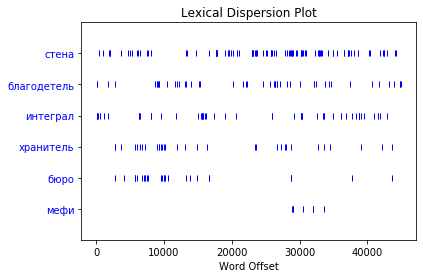

In [25]:
words = ["стена", "благодетель", "интеграл", "хранитель", "бюро", "мефи"]
nltk_lemmas.dispersion_plot(words)